# Tweets generation using Arabic ULMFIT model
### You can get this dataset using the Twitter API get an API key from [Here](https://developer.twitter.com/en/apply-for-access)
The Twitter API allows you to download up to 3,200 of a user's most recent Tweets which we will use for text generation.

#### Acknowledgment:
> The Idea is inspired by [ElBaradei Quote Generator](http://elbaradei.mandoz.com) by [@mand0z](https://twitter.com/mand0z) 

For more information about ULMFIT see [Paper](https://arxiv.org/abs/1801.06146) & [Blog post](http://nlp.fast.ai/).

### Using our pretrained Arabic ULMFIT language model we do the following:
1- Preprocess our dataset and get it ready for use in the coming steps by creating a language model databunch.

2- Load our language model with pretrained weights then fine-tune it to our dataset.

3- Use our fine-tuned Language model to generate tweets.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import path 
from fastai.text import *
import copy

In [3]:
import fastai; fastai.__version__

'1.0.51.dev0'

In [4]:
data_path = Path('data')
lm_path = Path('.')

*create a Dataframe out of the CSV file containing the dowloaded tweets*

In [7]:
tweets_df = pd.read_csv(data_path/'timeline.csv',low_memory=False)

In [8]:
tweets_df.head()

,id,created_at,text
0,1108793992584548352,Thu Mar 21 18:14:22 +0000 2019,إعلان الرئيس ترمب أنه حان الوقت لإعتراف الولاي...
1,1108789823433785344,Thu Mar 21 17:57:48 +0000 2019,"@realDonaldTrump This, Mr President is a gross..."
2,1108783929417449473,Thu Mar 21 17:34:23 +0000 2019,"بدأنا ""بغزوة الصناديق"" وتكفير المعترض؛ ثم بانت..."
3,1108451116034019328,Wed Mar 20 19:31:54 +0000 2019,ينتمي سكان نيوزيلاندا إلى ٢٠٠ أصل عرقي، يتكلم...
4,1108371822934982656,Wed Mar 20 14:16:49 +0000 2019,مصر التى أعرفها ؛ مصر التسامح، المحبة، الخلق، ...


* Create a Language model databunch that does all the necessary preprocessing like tokenization and numericalization.

* All the text in the dataset is concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

* We also create a validation set that is 10% of our full dataset (90% train 10% valid).

In [9]:
tweets_lm_data = (TextList.from_df(tweets_df,cols='text')
                   .split_by_rand_pct(.1)
                   .label_for_lm()
                   .databunch(bs=64))

In [10]:
tweets_lm_data.show_batch()

idx,text
0,"التسامح ، xxunk ، xxunk ، xxunk ... xxunk الله مرة أخرى \n \n https : / / t.co / xxunk xxbos xxunk xxmaj but xxup xxunk & & xxup iaea , the xxup un xxunk responsible for xxunk xxunk in xxmaj iraq were right & & clear in their xxunk # ! xxmaj that is why the xxup sc xxunk to xxunk use of force . xxmaj force"
1,"، xxunk البدائل المتاحة غير xxunk xxunk فى فترة إنتقالية xxunk xxunk xxunk والتوصل xxunk وطنية ؟ xxunk المسار xxunk دي xxunk أخرى ... xxbos xxup rt xxunk : xxmaj the xxup un said xxmaj israel committed "" serious violations of human rights "" during the xxmaj gaza protests in 2018 . https : / / t.co / xxunk xxbos xxunk أنا بالطبع ضد هذا الكلام البائس على طول xxunk"
2,"يناير ؟ xxunk xxunk فوق أنت مصري https : / / t.co / xxunk xxbos xxup rt xxunk : xxunk xxunk as a new member xxmaj dr elbaradei , xxmaj director xxmaj general xxmaj emeritus xxunk , xxmaj nobel xxmaj peace xxmaj prize laureate and the g … xxbos xxup rt xxunk : xxunk xxunk xxunk xxunk xxunk xxunk محمد البرادعي , xxunk العام xxunk xxunk الدولية xxunk xxunk …"
3,xxbos xxup rt xxunk : xxmaj xxunk xxmaj egyptian xxunk elbaradei xxunk that the death xxunk is xxunk ... xxmaj egyptian tv xxunk reports the xxunk by c … xxbos xxup rt @amreda2011 : @elbaradei الأمم المتحدة : xxunk xxunk في مصر xxunk بعد محاكمات xxunk xxunk \n \n https : / / t.co / xxunk xxbos أطالب xxunk إنسانية ( عيش ، حرية ، عدالة xxunk ) ؛
4,xxunk بكم xxunk الله xxbos النائب أحمد xxunk xxunk بشجاعة xxunk xxunk عن رأى كل من شارك فى ثورة يناير بشأن xxunk الدستورية https : / / t.co / xxunk xxbos xxunk xxunk xxunk xxunk الدكتور xxunk الغزالي حرب عن xxunk xxunk ... xxunk xxunk ... xxunk أن xxunk دون أن xxunk xxunk : لماذا xxunk الى هذا الحد من فقدان xxunk ؟ هل هى xxunk ؟ هل هو xxunk


*Save our databunch so we can load it instantly later if we want.*

In [11]:
tweets_lm_data.save('tweet_gen_lm')

In [5]:
tweets_lm_data = load_data(lm_path,'tweet_gen_lm', bs=64)

## 2- Fine-tune our LM to our Tweets:

In [6]:
pretrained_lm_fname = 'new_lm'
pretrained_itos_fname = 'itos'

* We will create a uni-directional [QRNN] (https://arxiv.org/abs/1611.01576) that will load our pre-trained language model weights stored in `new_lm.pth` and also load  `itos.pkl`  which contains our id to token mapping.
* We also pass it our language model databunch which we will fine-tune our language model to.

In [7]:
emb_sz:int = 400
nh: int = 1550
nl: int = 3

#We increase both dropout and regulazition so not to overfit as we have a small number of tweets
qrnn_config = copy.deepcopy(awd_lstm_lm_config)
dps = dict(output_p=0.35, hidden_p=0.2, input_p=0.3, embed_p=0.04, weight_p=0.25)
qrnn_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})

rnn_alpha: float = 3  # activation regularization (AR)
rnn_beta: float = 2  # temporal activation regularization (TAR)
drop_mult: float = 0.5
trn_args = dict(alpha=rnn_alpha, beta=rnn_beta,drop_mult=drop_mult)

qrnn_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [8]:
lm_learner = language_model_learner(tweets_lm_data, AWD_LSTM,config=qrnn_config, model_dir=lm_path, pretrained=False,pretrained_fnames=(pretrained_lm_fname,pretrained_itos_fname),**trn_args)

In [22]:
lm_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


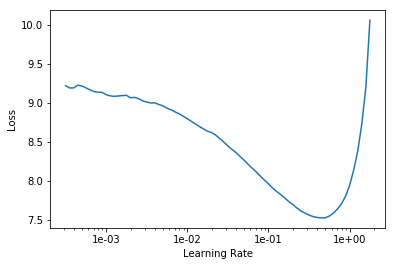

In [23]:
lm_learner.recorder.plot(skip_end=10)

*We train our model starting from the last layer then unfreezing the model and training the entire network*

In [24]:
lm_learner.fit_one_cycle(1,3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.239942,5.506410,0.294196,00:00


In [25]:
lm_learner.save('stage1-lm-1epoch')

In [10]:
lm_learner.unfreeze()

In [27]:
lm_learner.fit_one_cycle(5,3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.304472,5.032933,0.306920,00:00
1,5.821515,4.553542,0.330134,00:00
2,5.452939,4.388551,0.336049,00:00
3,5.206630,4.316796,0.338504,00:00
4,5.039281,4.306491,0.339063,00:00


In [29]:
lm_learner.save('stage2-lm-5epochs')

In [30]:
lm_learner.fit_one_cycle(10,3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.647152,4.276031,0.343973,00:00
1,4.609703,4.180850,0.347210,00:00
2,4.574903,4.175694,0.341295,00:00
3,4.517171,4.138391,0.343862,00:00
4,4.438974,4.021618,0.357589,00:00
5,4.345849,4.001579,0.353460,00:00
6,4.246330,3.953297,0.363281,00:00
7,4.146685,3.947753,0.364509,00:00
8,4.056401,3.937531,0.361161,00:00
9,3.987862,3.933597,0.361942,00:00


In [31]:
lm_learner.save('stage2-lm-15epochs')

**This is just for fun and as a proof of concept, it needs more research from me on text generation and also needs more data so waiting for more `@ElBaradei` Tweets :D**

In [12]:
text = "الشاورما السوري"
n_words = 10

In [15]:
lm_learner.predict(text, n_words)

'الشاورما السوري هى عدالة لا تقوم على مستوى معهم أن نعرف لا'